In [2]:
import math
import numpy as np
import torch
import matplotlib.pyplot as plt

### Utilities

In [3]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)

def init_mlp_weights(sizes, std=0.6):
    """Return [W1..W4] with Wi.shape = (sizes[i+1], sizes[i])"""
    weights = []
    for i in range(len(sizes)-1):
        W = torch.randn(sizes[i+1], sizes[i]) * std
        weights.append(W)
    return weights

def draw_network(weights, sizes, title="Network", max_edges_per_pair=800):
    """Simple layered plot; edge width ∝ |weight| (largest edges kept if too many)."""
    L = len(sizes)
    xs = np.linspace(0, 1, L)
    node_pos = []
    for li, n in enumerate(sizes):
        ys = np.linspace(0, 1, n)
        node_pos.append([(xs[li], y) for y in ys])

    plt.figure(figsize=(11, 6))
    ax = plt.gca(); ax.set_title(title); ax.set_axis_off()

    for li, W in enumerate(weights):
        src = node_pos[li]; dst = node_pos[li+1]
        Wnp = W.detach().cpu().numpy()
        rows, cols = Wnp.shape
        edges = [(i, j, Wnp[j, i]) for j in range(rows) for i in range(cols)]
        if len(edges) > max_edges_per_pair:
            edges.sort(key=lambda t: abs(t[2]), reverse=True)
            edges = edges[:max_edges_per_pair]
        if edges:
            mags = np.array([abs(e[2]) for e in edges])
            widths = 0.2 + 2.8 * (mags / (mags.max() + 1e-12))
            for (i, j, w), lw in zip(edges, widths):
                x1, y1 = src[i]; x2, y2 = dst[j]
                ax.plot([x1, x2], [y1, y2], linewidth=lw, alpha=0.6)

    for pos in node_pos:
        ax.scatter([p[0] for p in pos], [p[1] for p in pos], s=60, zorder=3)
    plt.show()

def frob(x: torch.Tensor) -> torch.Tensor:
    return torch.linalg.norm(x, ord='fro')

def end_to_end_map(weights):
    """Linearized input→output map."""
    A = weights[-1]
    for W in reversed(weights[:-1]):
        A = A @ W
    return A

### DA-style soft clustering (rows)

In [4]:
def _pairwise_sqeuclidean(X, Z):
    X2 = (X**2).sum(axis=1, keepdims=True)
    Z2 = (Z**2).sum(axis=1, keepdims=True).T
    return X2 + Z2 - 2 * (X @ Z.T)

def _soft_assign(D, beta):
    # Pc_{i j} ∝ exp(-β D_{i j})
    D = D - D.min(axis=1, keepdims=True)       # stabilize
    logits = -beta * D
    logits -= logits.max(axis=1, keepdims=True)
    P = np.exp(logits)
    P /= P.sum(axis=1, keepdims=True) + 1e-12
    return P

def _normalize_Q(Pc, mu):
    # Q_{i j} = mu_i * Pc_{i j} / sum_r mu_r * Pc_{r j}
    num = mu[:, None] * Pc
    den = num.sum(axis=0, keepdims=True) + 1e-12
    return num / den

def da_cluster_rows(W: torch.Tensor, M: int, beta=10.0, steps=200, tol=1e-6, seed=0):
    """
    Cluster the ROWS of W (N x D) into M prototypes Z (M x D).
    Returns: Pc (N x M), Z (M x D), info
    """
    rng = np.random.default_rng(seed)
    X = W.detach().cpu().numpy()
    N, D = X.shape
    mu = np.ones(N) / N
    idx = rng.choice(N, size=M, replace=False)
    Z = X[idx].copy() + 1e-6 * rng.standard_normal((M, D))

    prevF = np.inf
    hist = []
    for t in range(steps):
        Dmat = _pairwise_sqeuclidean(X, Z)
        Pc = _soft_assign(Dmat, beta)
        Qc = _normalize_Q(Pc, mu)
        Z = Qc.T @ X

        # soft-min objective
        Dmat = _pairwise_sqeuclidean(X, Z)
        shifted = -beta * (Dmat - Dmat.min(axis=1, keepdims=True))
        logsumexp = np.log(np.exp(shifted).sum(axis=1)) - beta * (-Dmat.min(axis=1))
        F = - (mu * logsumexp).sum() / beta
        hist.append(F)
        if abs(prevF - F) < tol * (1 + abs(F)):
            break
        prevF = F

    info = {"iters": t+1, "F": float(F), "history_len": len(hist)}
    return Pc, Z, info


### Layer aggregation

In [5]:
def aggregate_layer(weights, sizes, hidden_layer_index, M, beta=10.0, seed=0):
    """
    Compress hidden layer 'hidden_layer_index' (in terms of sizes).
    weights[k] maps sizes[k] -> sizes[k+1].
    We cluster rows of W_prev = weights[hidden_layer_index-1],
    and right-multiply W_next = weights[hidden_layer_index] by Pc.
    Returns: new_weights, new_sizes, metrics (with Pc/Z and pre-compression W_prev/W_next for block metrics).
    """
    assert 0 < hidden_layer_index < len(sizes)-1, "hidden_layer_index must refer to a hidden layer."

    W_prev = weights[hidden_layer_index - 1]    # shape (old_width, in_dim)
    W_next = weights[hidden_layer_index]        # shape (out_dim, old_width)
    old_width = sizes[hidden_layer_index]
    assert W_prev.shape[0] == old_width and W_next.shape[1] == old_width

    Pc, Z, info = da_cluster_rows(W_prev, M=M, beta=beta, steps=200, seed=seed)  # Pc: (old_width, M), Z: (M, in_dim)

    W_prev_new = torch.tensor(Z, dtype=W_prev.dtype)                 # (M, in_dim)
    W_next_new = W_next @ torch.tensor(Pc, dtype=W_next.dtype)       # (out_dim, M)

    # Reconstruction diagnostics
    W_prev_approx = torch.tensor(Pc, dtype=W_prev.dtype) @ torch.tensor(Z, dtype=W_prev.dtype)
    rel_err_prev = (frob(W_prev - W_prev_approx) / (frob(W_prev) + 1e-12)).item()
    W_next_back = W_next_new @ torch.tensor(Pc, dtype=W_next.dtype).T
    rel_err_next = (frob(W_next - W_next_back) / (frob(W_next) + 1e-12)).item()

    # Splice into new weight list
    new_weights = []
    for k, W in enumerate(weights):
        if k == hidden_layer_index - 1:
            new_weights.append(W_prev_new)
        elif k == hidden_layer_index:
            new_weights.append(W_next_new)
        else:
            new_weights.append(W.clone())

    new_sizes = sizes.copy()
    new_sizes[hidden_layer_index] = M

    metrics = {
        "layer_index": int(hidden_layer_index),
        "old_width": int(old_width),
        "new_width": int(M),
        "rel_err_W_prev": float(rel_err_prev),
        "rel_err_W_next": float(rel_err_next),
        "da_info": info,
        # store what we need for local block comparisons
        "Pc": Pc, "Z": Z,
        "W_prev_before": W_prev.clone(),   # (old_width, in_dim)
        "W_next_before": W_next.clone(),   # (out_dim, old_width)
    }
    return new_weights, new_sizes, metrics

### Run the experiment

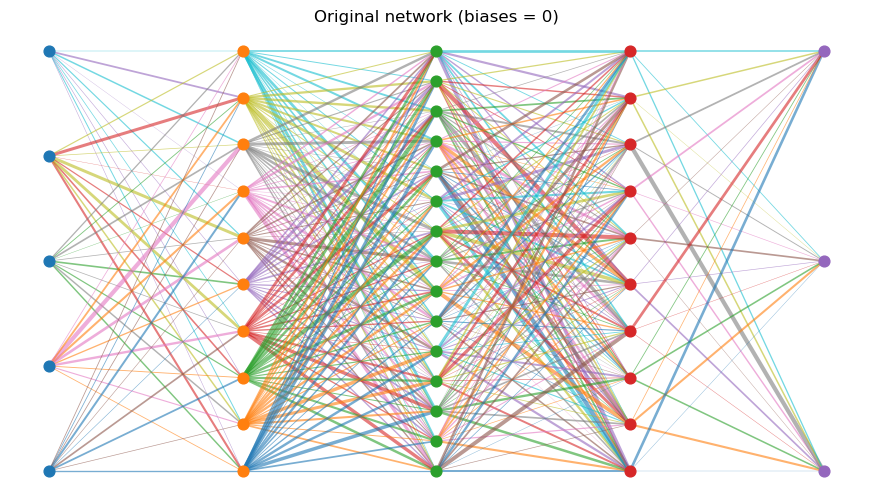

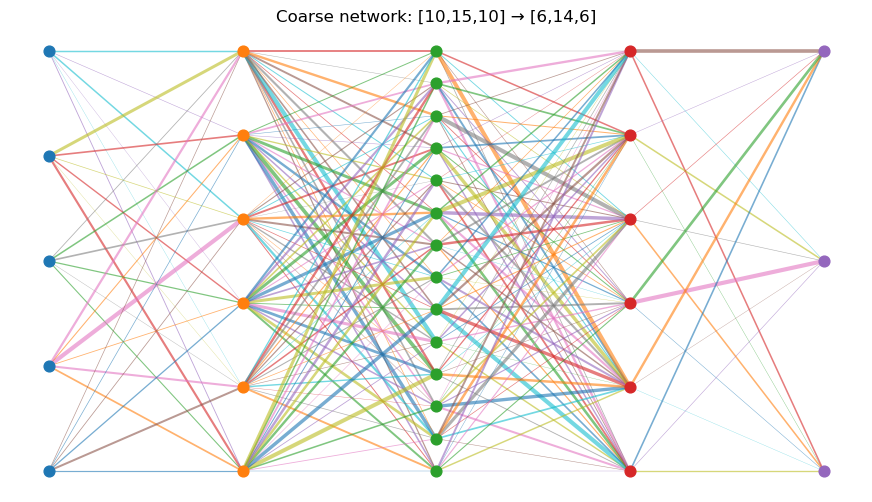

In [14]:
set_seed(7)
sizes = [5, 10, 15, 10, 3]
weights = init_mlp_weights(sizes, std=0.6)

draw_network(weights, sizes, title="Original network (biases = 0)")

# Choose compressed widths
M1, M2, M3 = 6, 14, 6
beta = 10.0

# Step 1: compress hidden layer 1 (size 10 -> M1)
weights1, sizes1, m1 = aggregate_layer(weights, sizes, hidden_layer_index=1, M=M1, beta=beta, seed=11)

# Step 2: compress hidden layer 2 (size 15 -> M2) on the updated network
weights2, sizes2, m2 = aggregate_layer(weights1, sizes1, hidden_layer_index=2, M=M2, beta=beta, seed=12)

# Step 3: compress hidden layer 3 (size 10 -> M3) on the updated network
weights3, sizes3, m3 = aggregate_layer(weights2, sizes2, hidden_layer_index=3, M=M3, beta=beta, seed=13)

draw_network(weights3, sizes3, title=f"Coarse network: [10,15,10] → [{M1},{M2},{M3}]")

### Dissimilarity metrics

In [15]:

# 1) End-to-end (linearized)
A_orig   = end_to_end_map(weights)
A_coarse = end_to_end_map(weights3)
rel_err_global = (frob(A_orig - A_coarse) / (frob(A_orig) + 1e-12)).item()

# 2) Local two-layer block errors around each compressed layer
# For a hidden layer with W_prev (in→hidden) and W_next (hidden→out),
# original composite:    B = W_next @ W_prev
# compressed composite: B' = (W_next @ Pc) @ Z
def block_rel_error(W_prev, W_next, Pc, Z):
    B  = W_next @ W_prev
    Bp = (W_next @ torch.tensor(Pc, dtype=W_next.dtype)) @ torch.tensor(Z, dtype=W_prev.dtype)
    return (frob(B - Bp) / (frob(B) + 1e-12)).item()

rel_err_B1 = block_rel_error(m1["W_prev_before"], m1["W_next_before"], m1["Pc"], m1["Z"])
rel_err_B2 = block_rel_error(m2["W_prev_before"], m2["W_next_before"], m2["Pc"], m2["Z"])
rel_err_B3 = block_rel_error(m3["W_prev_before"], m3["W_next_before"], m3["Pc"], m3["Z"])

# 3) Per-layer recon errors already computed: rel_err_W_prev, rel_err_W_next

print("Per-layer DA metrics:")
for tag, m in [("Step1", m1), ("Step2", m2), ("Step3", m3)]:
    print(f" {tag} | layer {m['layer_index']}: {m['old_width']} → {m['new_width']}"
          f" | recon(W_prev)={m['rel_err_W_prev']:.4f}"
          f" | recon(W_next via Pc)={m['rel_err_W_next']:.4f}"
          f" | DA iters={m['da_info']['iters']}")

print("\nLocal block dissimilarities (two-layer composites around each compressed layer):")
print(f" B1 (W2@W1 vs (W2@Pc1)@Z1): {rel_err_B1:.4f}")
print(f" B2 (W3@W2 vs (W3@Pc2)@Z2): {rel_err_B2:.4f}")
print(f" B3 (W4@W3 vs (W4@Pc3)@Z3): {rel_err_B3:.4f}")


Per-layer DA metrics:
 Step1 | layer 1: 10 → 6 | recon(W_prev)=0.2451 | recon(W_next via Pc)=0.9227 | DA iters=4
 Step2 | layer 2: 15 → 14 | recon(W_prev)=0.1244 | recon(W_next via Pc)=0.3496 | DA iters=2
 Step3 | layer 3: 10 → 6 | recon(W_prev)=0.5155 | recon(W_next via Pc)=1.3017 | DA iters=2

Local block dissimilarities (two-layer composites around each compressed layer):
 B1 (W2@W1 vs (W2@Pc1)@Z1): 0.2129
 B2 (W3@W2 vs (W3@Pc2)@Z2): 0.0616
 B3 (W4@W3 vs (W4@Pc3)@Z3): 0.4373
